# Fake News Prediction: Machine Learning Classifier Models 

## Import Dependencies

In [111]:
from google.colab import drive
drive.mount('drive')
import pandas as pd
from io import StringIO
import requests
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Load Data into DataFrames

In [112]:
fake_url="https://raw.githubusercontent.com/Shannon-Watts/fake_news_ML/main/data/kaggle/Fake.csv"
fake_request = requests.get(fake_url).text
fake_df = pd.read_csv(StringIO(fake_request))
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [113]:
true_url= "https://raw.githubusercontent.com/Shannon-Watts/fake_news_ML/main/data/kaggle/True.csv"
true_request = requests.get(true_url).text
true_df = pd.read_csv(StringIO(true_request))
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Data Exploration

In [114]:
fake_df.nunique()

title      17903
text       17455
subject        6
date        1681
dtype: int64

In [115]:

true_df.nunique()

title      20826
text       21192
subject        2
date         716
dtype: int64

In [116]:
fake_df['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [117]:
true_df['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [118]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [119]:
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [120]:
fake_df.duplicated().sum()

3

In [121]:
true_df.duplicated().sum()

206

In [122]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [123]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [124]:
fake_df.shape

(23481, 4)

In [72]:
true_df.shape

(21417, 4)

## Data Transformation
### Add `class` column, merge Dataframes, Clean Data

In [125]:
true_df['class'], fake_df['class'] = 1, 0

merged_df = pd.concat([true_df, fake_df], ignore_index = True, sort = False)

In [126]:
import copy
news_df = copy.deepcopy(merged_df)

In [127]:
import re
URLS = r'(https?://\S+)'
news_df['urlcount'] = news_df['date'].apply(lambda x: re.findall(URLS, x)).str.len()

news_df.loc[news_df['urlcount'] > 0]

,title,text,subject,date,class,urlcount
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0,1
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,0,1
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0,1
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0,1
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0,1
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0,1
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0,1
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0,1
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0,1


In [128]:
news_df['urlcount'].sum()

9

In [129]:
news_df.drop(news_df.loc[news_df['urlcount'] > 0].index, inplace=True)

In [130]:
news_df['urlcount'].sum()

0

In [131]:
news_df.duplicated().sum()

209

In [132]:
news_df.drop_duplicates(inplace=True)

In [133]:
news_df.duplicated().sum()

0

In [134]:
news_df.columns

Index(['title', 'text', 'subject', 'date', 'class', 'urlcount'], dtype='object')

In [135]:
news_df.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44680 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44680 non-null  object
 1   text      44680 non-null  object
 2   subject   44680 non-null  object
 3   date      44680 non-null  object
 4   class     44680 non-null  int64 
 5   urlcount  44680 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [136]:
news_df.shape

(44680, 6)

In [137]:
news_df['class'].value_counts()

0    23469
1    21211
Name: class, dtype: int64

In [138]:
news_df['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6833
left-news           4457
Government News     1568
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [139]:
news_df.drop(['text', 'date', 'subject', 'urlcount'], axis = 1, inplace = True)
news_df

,title,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44896,How to Blow $700 Million: Al Jazeera America F...,0


In [92]:
news_df.shape

(44680, 2)

In [140]:
news_df

,title,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44896,How to Blow $700 Million: Al Jazeera America F...,0


In [143]:
news_df.to_csv('news_df.csv', encoding='utf-8', index=False)
!cp news_df.csv "drive/My Drive/"

In [144]:
news_df.columns

Index(['title', 'class'], dtype='object')

In [146]:
# Shuffle the rows randomly
news_df = news_df.sample(frac = 1)

## Data Preprocessing

In [147]:
# Import Dependencies for preprocessing
import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [148]:
news_df.head()

,title,class
28096,You Won’t Believe What This Michigan Teacher ...,0
8792,U.S. attorney general deflects lawmakers' ques...,1
34460,WOW! OBAMA Just DESTROYED Hillary With This Tw...,0
9408,Obama prods Vietnam on rights after activists ...,1
37885,BREAKING: Did Hillary’s Unsecured CLASSIFIED E...,0


In [154]:
# Create function to lower_case all title text data 
def lower_title(x):
  try:
    return x.lower()
  except Exception as e:
    print('Error in lower_title function', str(e))
    print("Error", x)
    return x

In [155]:
# Create function for preprocessing Title Text data

def process_text(dataframe=None, column=None):

      porter = PorterStemmer()
      tokenizer = RegexpTokenizer(r'\w+')

      dataframe[column] = dataframe[column].replace('[^a-zA-Z0-9]', '')
      dataframe[column] = dataframe[column].apply(lambda x: lower_title(x))

      dataframe = dataframe.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
      dataframe[column] = dataframe[column].apply(lambda x:tokenizer.tokenize(x))
      eng_stopwords = stopwords.words('english') 

      dataframe[column] =dataframe[column].apply(lambda words: [word for word in words if word not in eng_stopwords])
      dataframe[column] = dataframe[column].apply(lambda x : ' '.join([porter.stem(token) for token in x]))

In [156]:
# Run the function on the title column
process_text(dataframe=news_df, column='title')

In [157]:
news_df

,title,class
28096,you won’t believe what this michigan teacher ...,0
8792,u.s. attorney general deflects lawmakers' ques...,1
34460,wow! obama just destroyed hillary with this tw...,0
9408,obama prods vietnam on rights after activists ...,1
37885,breaking: did hillary’s unsecured classified e...,0
...,...,...
23949,joy behar humiliates trump for flynn resignat...,0
23485,fox & friends ignores fbi director’s trump bo...,0
35081,hillary on disabled children during easter egg...,0
37755,revealed: hillary’s over-the-top spending duri...,0


In [158]:
news_df['class'].value_counts()

0    23469
1    21211
Name: class, dtype: int64

## Compile, Fit (Train) and Evaluate the Models

In [103]:
# Import Dependencies for ML models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn import svm

In [104]:
# Split Data into Target and Label and then into Test and Train 
x = news_df['title']
y = news_df['class']
X_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)

In [105]:
# Vectorize title text to numbers
vec = CountVectorizer(stop_words='english')
X_train = vec.fit_transform(X_train).toarray()
x_test = vec.transform(x_test).toarray()

In [106]:
# Creat function to train mutliple classifiers
def train_models(classifier_list=None, X_train=None, y_train=None, x_test=None, y_test=None):
  final_results = list()
  for name, classifier in classifier_list:
    print(f'Training {classifier}')
    classifier.fit(X_train, y_train)
   
    y_pred = classifier.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    f1score = f1_score(y_pred, y_test)

    final_results.append((name, accuracy, recall, precision, f1score))
    print(f'Accuracy is ==> {accuracy}')
  
  return pd.DataFrame(final_results, columns=['classifier','accuracy', 'recall', 'precision', 'f1_score'])

In [48]:
# List of our Classifier Models
models_list = [
    ('MultinomialNB', MultinomialNB()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('PassiveAggressiveClassifier', PassiveAggressiveClassifier()),
    ('SVC', SVC())
]

In [49]:
# Fit (train) the data using the train_models function with our classiefiers list
results_df = train_models(classifier_list=models_list, X_train=X_train, y_train=y_train, x_test=x_test, y_test=y_test)
sorted_results = results_df.sort_values(by='accuracy', ascending=False)

Training MultinomialNB()
Accuracy is ==> 0.9333930170098478
Training RandomForestClassifier()
Accuracy is ==> 0.9361683079677708
Training AdaBoostClassifier()
Accuracy is ==> 0.8461056401074306
Training KNeighborsClassifier()
Accuracy is ==> 0.7630259623992838
Training PassiveAggressiveClassifier()
Accuracy is ==> 0.9427931960608773
Training SVC()
Accuracy is ==> 0.9512085944494181


In [50]:
sorted_results

,classifier,accuracy,recall,precision,f1_score
5,SVC,0.951209,0.928649,0.971903,0.949783
4,PassiveAggressiveClassifier,0.942793,0.935562,0.944560,0.940039
1,RandomForestClassifier,0.936168,0.918796,0.949463,0.933877
0,MultinomialNB,0.933393,0.940483,0.917782,0.928994
2,AdaBoostClassifier,0.846106,0.776714,0.948520,0.854062
3,KNeighborsClassifier,0.763026,0.831007,0.628701,0.715835


Mounted at drive


In [109]:
# Save the dataframe holding classifier models result as csv 
sorted_results.to_csv('classifier_models.csv', encoding='utf-8', index=False)
!cp classifier_models.csv "drive/My Drive/"

In [51]:
# Plot the resulst
# results_df.plot.bar(x='classifier', y='accuracy', rot=45)
import plotly.express as px

fig = px.bar(sorted_results, x='classifier', y='accuracy', text_auto='.2f', 
            title="Fake News Prediction Models Accuracy Score")
fig.show()

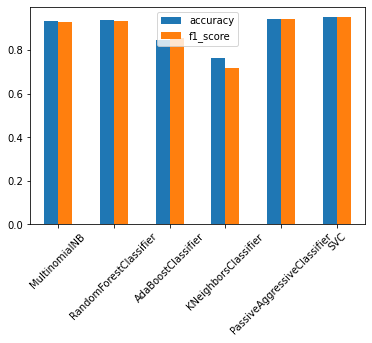

In [52]:
# Dataframe comapring classifier models results
comparison_df = pd.DataFrame({'accuracy': list(results_df['accuracy']),
                   'f1_score': list(results_df['f1_score'])}, index=list(results_df['classifier']))
ax = comparison_df.plot.bar(rot=45)

In [53]:
comparison_df = comparison_df.sort_values(by='accuracy', ascending=False)
comparison_df

,accuracy,f1_score
SVC,0.951209,0.949783
PassiveAggressiveClassifier,0.942793,0.940039
RandomForestClassifier,0.936168,0.933877
MultinomialNB,0.933393,0.928994
AdaBoostClassifier,0.846106,0.854062
KNeighborsClassifier,0.763026,0.715835


In [159]:
import plotly.graph_objects as go

# Plot the accuracy and f1 scores
fig2 = go.Figure(
    data=[
        go.Bar(
            name="accuracy",
            x=sorted_results["classifier"],
            y=sorted_results["accuracy"],
            textposition='auto',
            offsetgroup=0,
        ),
        go.Bar(
            name="f1_score",
            x=sorted_results["classifier"],
            y=sorted_results["f1_score"],
            textposition='auto',
            offsetgroup=1,
        ),
    ],
    layout=go.Layout(
        title="Fake News Prediction Models Scores",
        yaxis_title="Score"
    )
)
fig2.show()

In [110]:
# Save the comparison datafarme of classifier models to csv
comparison_df.to_csv('comparison.csv', encoding='utf-8', index=False)
!cp comparison.csv "drive/My Drive/"